In [1]:
import numpy as np

In [979]:
def gp(X, y, k, Xtest, noise=1e-6):
    X_m, X_n = X.shape
    K = k(X, X)
    
    L = np.linalg.cholesky(K + noise*np.eye(X_m)) # decompose K for inverse stability
    Kx = k(X, Xtest)
    LKx = np.linalg.solve(L, Kx) # Ax=b Lkx = L^-1 * Kx
    
    Kxx = k(Xtest, Xtest)

    mean = np.dot(LKx.T, np.linalg.solve(L, y)) # L*^T * (L^-1 *y)
    var = np.diag(Kxx) - np.sum(LKx**2, axis=0) # variance of f*  equation 1.3
    # loglike = - 1/2 * y.T * a - np.trace(np.log(L)) - X_n / 2 * np.log(2 * np.pie) # likelihood of f*
    LKxx = np.linalg.cholesky(Kxx + 1e-6 * np.eye(Xtest.shape[0]) - np.dot(LKx.T, LKx))
    f_posterior = mean + np.dot(LKxx, np.random.normal(size=(Xtest.shape[0], 40)))

    return mean, var, f_posterior

In [980]:
def RBF(a, b, l=0.3):
    dotprod = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
 
    return np.exp((-1/(2 *(l**2))) * dotprod)

In [981]:
def hard_sin(x):
    return np.sin(x)

hard_sin_f = np.vectorize(hard_sin)

In [1012]:
def uc(X, Xtest, k, variance=0.05, noise=1e-6):
    K = k(X, X)
    lambdas, _ = np.linalg.eigh(K)
    
    sorted_indices = np.argsort(lambdas)[::-1]
    lambdas = lambdas[sorted_indices]

    I = np.eye(K.shape[0])
    K = lambdas * I

    K_inv = np.linalg.solve(K + noise * I, I)
    uc_n = np.trace(np.linalg.solve(K_inv + (1/variance) * len(X) * I, I)) # equation 2.8

    return uc_n


In [1013]:
def lc(X, Xtest, k, variance=0.09, noise=1e-6):
    K = k(X, X)
    lambdas, _ = np.linalg.eigh(K)
    
    sorted_indices = np.argsort(lambdas)[::-1]
    lambdas = lambdas[sorted_indices]

    I = np.eye(K.shape[0])
    K = lambdas * I

    K_inv = np.linalg.solve(K + noise * I, I)
    uc_n = np.trace(np.linalg.solve(K_inv + (len(X) /variance) * I, I)) # equation 2.8

    return uc_n


In [1014]:
n_train = 30
n_test = 100

f = lambda x: np.sin(x)

X = np.random.uniform(-5, 5, size=(n_train, 1))
y = f(X)

Xtest = np.linspace(-5, 5, n_test).reshape(-1,1)

In [1015]:
import matplotlib.pyplot as plt

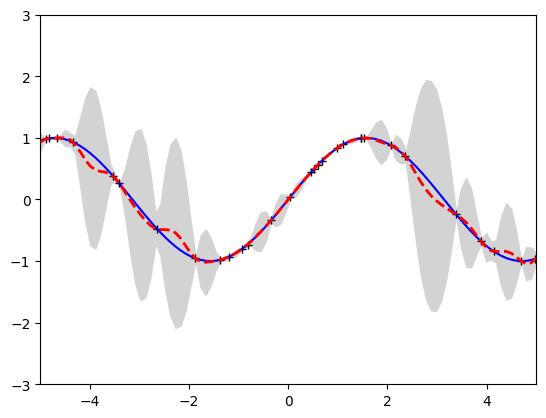

In [1016]:
plt.plot(X, y, 'k+')
plt.axis([-5, 5, -3, 3])
plt.plot(Xtest, hard_sin_f(Xtest),'b-')
test_mean, test_var, f_posterior = gp(X, y, RBF, Xtest)
test_std = np.sqrt(test_var)
plt.gca().fill_between(Xtest.flatten(), test_mean.flatten() - 2*test_std, test_mean.flatten() + 2*test_std, color="lightgrey")
plt.plot(Xtest, test_mean, 'r--', lw=2)


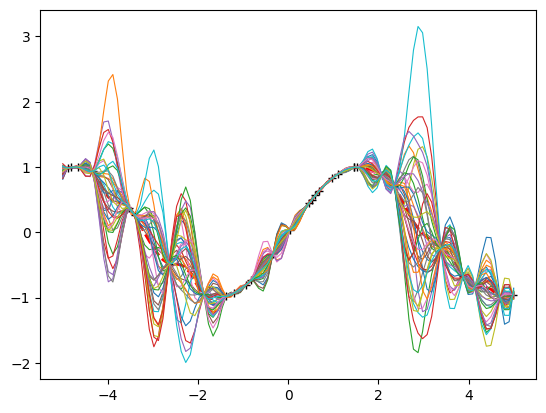

In [1017]:
plt.clf()
plt.plot(X, y, 'k+')
plt.plot(Xtest, test_mean, 'r--', linewidth=2)
plt.plot(Xtest, f_posterior, linewidth=0.8)
plt.show()

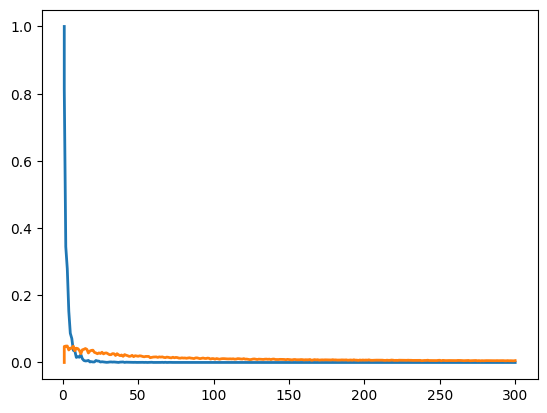

In [1028]:
n_max = 300
dim = 1

np.random.seed(123)

X = np.empty((0, dim))
y = np.empty((0, dim))

n_arr = np.array(range(0, n_max + 1))
n_arr[0] = 1

ge = np.empty((0, 1))
uc_arr = np.empty((0, 1))
lc_arr = np.empty((0, 1))


for n in range(0, n_max + 1):
    X = np.random.normal(0, 1, size=(n, dim))
    if n == 0:
        y = np.empty((0, 1))
    else:
        y = hard_sin_f(X)
        
    Xtest = np.random.normal(0, 1, size=(100, dim))
    ytest = hard_sin_f(Xtest)
    mean,vs, _ = gp(X, y, RBF, Xtest)

    uc_n = uc(X, Xtest, RBF)
    lc_n = lc(X, Xtest, RBF)

    ge = np.vstack((ge, np.sum(vs)/len(Xtest))) # equation 1.3
    
    uc_arr = np.vstack((uc_arr, [[uc_n]]))
    lc_arr = np.vstack((lc_arr, [[lc_n]]))


x_size = np.array(range(0, n_max + 1))
x_size[0] = 1
plt.plot(n_arr, ge.flatten() / x_size, linewidth=2)
plt.plot(n_arr, uc_arr, linewidth=2)
# plt.plot(n_arr, lc_arr, linewidth=2)

plt.show()